<a href="https://colab.research.google.com/github/KostaKat/Fire-Mask-Prediction/blob/package/notebooks/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
!git clone https://github.com/KostaKat/Fire-Mask-Prediction.git

Cloning into 'Fire-Mask-Prediction'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 98 (delta 48), reused 27 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 433.30 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
%cd Fire-Mask-Prediction/

/content/Fire-Mask-Prediction


In [3]:
!git checkout package

Branch 'package' set up to track remote branch 'package' from 'origin'.
Switched to a new branch 'package'


In [5]:
!git pull

Already up to date.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from typing import Dict, List, Optional, Tuple
from typing_extensions import Text
import tensorflow as tf
import re
from data_utils import *
from data_utils.data_cons import INPUT_FEATURES, OUTPUT_FEATURES, TITLES
from data_utils.parse_files import get_dataset
from data_utils.augs import random_crop_input_and_output_images

In [9]:
import matplotlib.pyplot as plt
from matplotlib import colors
BATCH_SIZE = 32
dataset = get_dataset('/content/drive/MyDrive/mat422_project/dataset/next_day_wildfire_spread_train*',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

#Plot dataset

In [10]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.

    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break

    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()


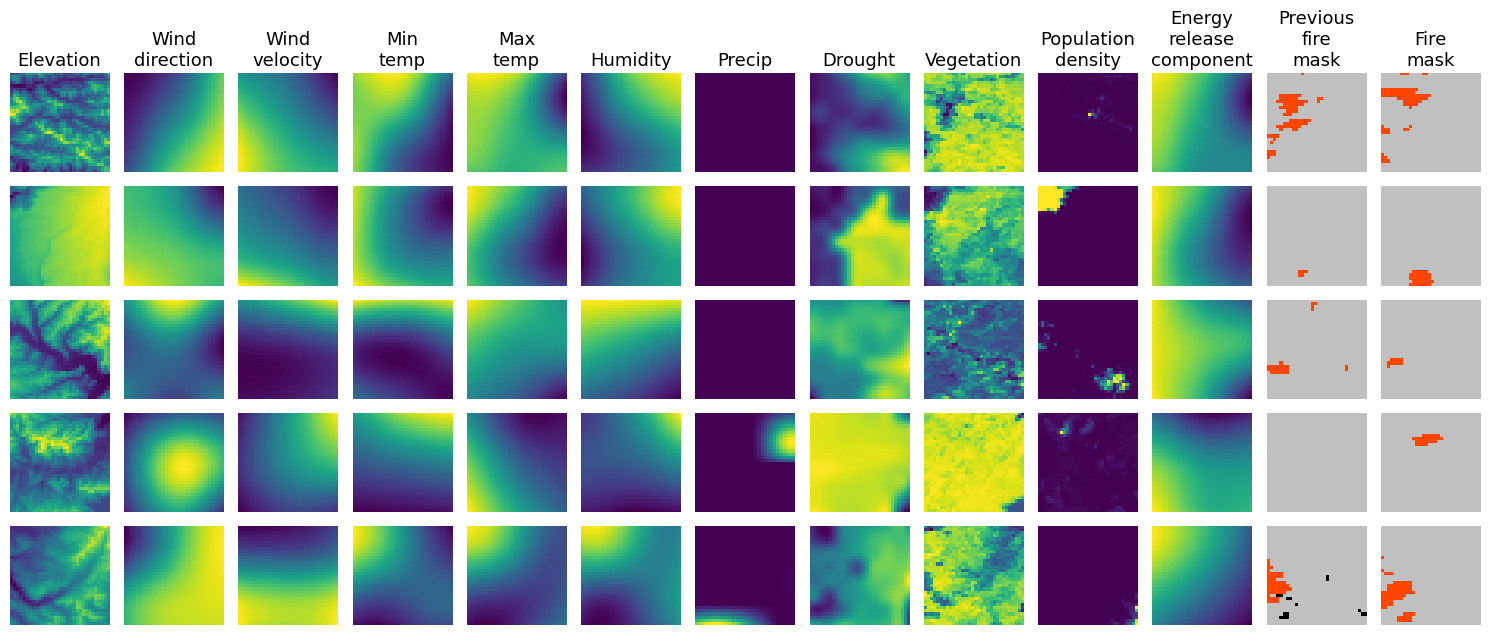

In [13]:
plot_samples_from_dataset(dataset, 5) #n_rows = 5